Importing Libraries and connecting drive for saved models.

In [ ]:
!pip  install imagecorruptions

from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from imagecorruptions import corrupt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE

!pip install imagecorruptions -q

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/SimCLR_Project_Files'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# CHANGE THIS TO TRUE IF TRAINING FROM SCRATCH
TRAIN_FROM_SCRATCH = False
print(f"Setup Complete. Device: {device}")
print(f"Training Mode: {'ENABLED' if TRAIN_FROM_SCRATCH else 'DISABLED (Loading Saved Models)'}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.4 MB/s eta 0:00:00
Mounted at /content/drive
Setup Complete. Device: cuda
Training Mode: ENABLED


Loading Data

In [ ]:
class selfsupervisedloader:
    def __init__(self, size=32):
        s = 0.5
        self.transform = T.Compose([
            T.RandomResizedCrop(size=size),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

clean_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

print("⏳ Loading CIFAR-10...")

train_set_simclr = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=selfsupervisedloader(), download=True
)
train_loader_simclr = DataLoader(train_set_simclr, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

train_set_clean = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=clean_transform, download=True
)
train_loader_clean = DataLoader(train_set_clean, batch_size=128, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, transform=None, download=True
)

print("Data Loaded: 'train_loader_simclr' and 'train_loader_clean' are ready.")

⏳ Loading CIFAR-10...


100%|██████████| 170M/170M [00:05<00:00, 30.7MB/s]


Data Loaded: 'train_loader_simclr' and 'train_loader_clean' are ready.


Defining Selfsupervised model

In [ ]:
class selfsupervised(nn.Module):
    def __init__(self, base_model="resnet18", out_dim=128):
        super(selfsupervised, self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=False)

        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.maxpool = nn.Identity()

        dim_mlp = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.projection_head = nn.Sequential(
            nn.Linear(dim_mlp, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.backbone(x)
        h = h.view(h.shape[0], -1)
        z = self.projection_head(h)
        return h, z

model = selfsupervised().to(device)
print("Unsupervised Model Initialized")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Unsupervised Model Initialized


Training and Calculating Losses

In [ ]:
class Loss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.mask = self.mask_correlated_samples(batch_size)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=torch.bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size
        z = torch.cat((z_i, z_j), dim=0)
        sim = torch.matmul(z, z.T) / self.temperature
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        return self.criterion(logits, labels) / N

if TRAIN_FROM_SCRATCH:
    model = selfsupervised().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    loss_fn = Loss(batch_size=128, temperature=0.5)
    epochs = 100

    print(f"Starting SimCLR Training ({epochs} epochs)")

    loss_history = []

    for i in range(epochs):
        total_loss = 0
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {i+1}/{epochs}")

        for (x_i, x_j), _ in loop:
            x_i, x_j = x_i.to(device), x_j.to(device)
            optimizer.zero_grad()
            _, z_i = model(x_i)
            _, z_j = model(x_j)
            z_i = F.normalize(z_i, dim=1)
            z_j = F.normalize(z_j, dim=1)
            loss = loss_fn(z_i, z_j)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)

    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title("Self-Supervised Training Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Directly Loading Saved Model later)")

Directly Loading Saved Model later)


Linear Evaluaton

In [ ]:
import torch.nn as nn

class RobustClassifier(nn.Module):
  def __init__(self, encoder):
    super().__init__()
    self.encoder = encoder
    self.fc = nn.Linear(512, 10)

  def forward(self, x):
    with torch.no_grad():
      h, _ = self.encoder(x)
    return self.fc(h)

print("Class defined")

Class defined


🛠️ Initializing Models...
⏳ Loading Pre-Trained SimCLR Backbone...
✅ Loaded saved weights! Starting Linear Eval...
🚀 Starting Linear Evaluation (Frozen Backbone)...


Linear Eval Epoch 20/20: 100%|██████████| 391/391 [00:15<00:00, 25.97it/s, loss=0.384]


✅ Linear Evaluation Complete!
🔗 Updating Graphing Model...
✅ Success! Ready for Graphs.


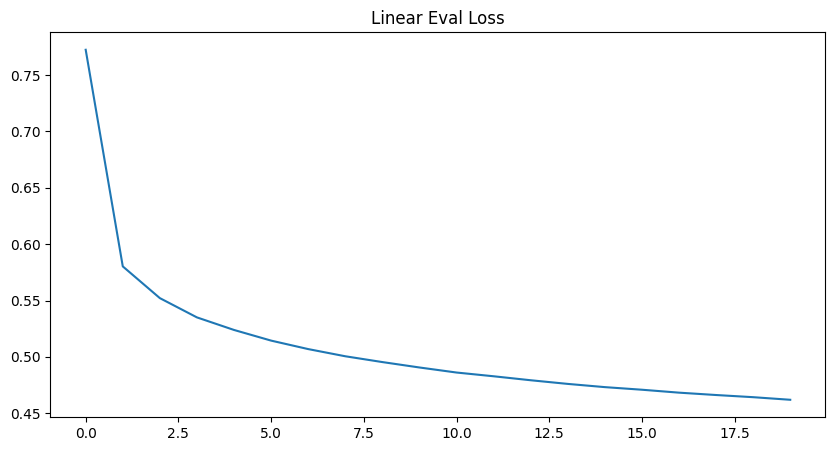

In [ ]:
if TRAIN_FROM_SCRATCH:
    model = selfsupervised().to(device)

    try:
        model.load_state_dict(torch.load(f'{project_path}/simclr_backbone.pth', map_location=device), strict=False)
        print("Loaded saved weights")
    except FileNotFoundError:
        print("Saved model not found. Using random weights.")

    for param in model.backbone.parameters():
        param.requires_grad = False

    model.eval()

    classifier_head = nn.Linear(512, 10).to(device)

    clf_optimizer = torch.optim.Adam(classifier_head.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    EPOCHS_FINE = 20
    loss_history_ft = []

    for i in range(EPOCHS_FINE):
        total_loss = 0
        loop = tqdm(train_loader_clean, desc=f"Linear Eval Epoch {i+1}/{EPOCHS_FINE}")

        for x, y in loop:
            x, y = x.to(device), y.to(device)

            with torch.no_grad():
                h = model.backbone(x)
                h = h.view(h.size(0), -1)

            logits = classifier_head(h)

            clf_optimizer.zero_grad()
            loss = criterion(logits, y)
            loss.backward()
            clf_optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        loss_history_ft.append(total_loss / len(train_loader_clean))

    print("Linear Evaluation Complete")

    eval_backbone = selfsupervised()
    simclr_model = RobustClassifier(eval_backbone).to(device)

    simclr_model.encoder.load_state_dict(model.state_dict())
    simclr_model.fc.load_state_dict(classifier_head.state_dict())

    simclr_model.eval()
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history_ft)
    plt.title("Linear Eval Loss")
    plt.show()

else:
    print("Skipping Linear Eval")

Supervised Model

In [ ]:
if TRAIN_FROM_SCRATCH:
    supervised_model = torchvision.models.resnet18(pretrained=False)
    supervised_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    supervised_model.maxpool = nn.Identity()
    supervised_model.fc = nn.Linear(512, 10)
    supervised_model = supervised_model.to(device)

    optimizer_b = torch.optim.Adam(supervised_model.parameters(), lr=1e-3)
    criterion_b = nn.CrossEntropyLoss()

    print("🚀 Training Supervised Baseline...")
    supervised_model.train()
    for i in range(20):
        loop = tqdm(train_loader_clean, desc=f"Epoch {i+1}/20")
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            optimizer_b.zero_grad()
            logits = supervised_model(x)
            loss = criterion_b(logits, y)
            loss.backward()
            optimizer_b.step()
else:
    print("Skipping Supervised Training (Loading Saved Model later)")

🚀 Training Supervised Baseline...


Epoch 20/20: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]


Saving models

In [ ]:
if TRAIN_FROM_SCRATCH:
    print("Saving New Models to Google Drive...")

    torch.save(model.state_dict(), f'{project_path}/simclr_backbone.pth')

    torch.save(classifier_head.state_dict(), f'{project_path}/simclr_classifier.pth')

    torch.save(supervised_model.state_dict(), f'{project_path}/supervised_baseline.pth')

    print(f"Saved successfully to: {project_path}")
else:
    print("Skipped saving (Protected Mode: No new training occurred)")

Saving New Models to Google Drive...
Saved successfully to: /content/drive/MyDrive/SimCLR_Project_Files


Loading Models

In [ ]:
print("Loading Models from Google Drive.")

simclr_backbone = selfsupervised()
simclr_model = RobustClassifier(simclr_backbone).to(device)

supervised_model = torchvision.models.resnet18(pretrained=False)
supervised_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
supervised_model.maxpool = nn.Identity()
supervised_model.fc = nn.Linear(512, 10)
supervised_model = supervised_model.to(device)

try:
    simclr_model.encoder.load_state_dict(torch.load(f'{project_path}/simclr_backbone.pth', map_location=device))

    simclr_model.fc.load_state_dict(torch.load(f'{project_path}/simclr_classifier.pth', map_location=device))

    supervised_model.load_state_dict(torch.load(f'{project_path}/supervised_baseline.pth', map_location=device))

    simclr_model.eval()
    supervised_model.eval()
    print("Success! All models loaded")

except FileNotFoundError:
    print("Could not find .pth files")
except Exception as e:
    print(f"Error loading models")

Loading Models from Google Drive.
Success! All models loaded


Visualizing Unsupervised model

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


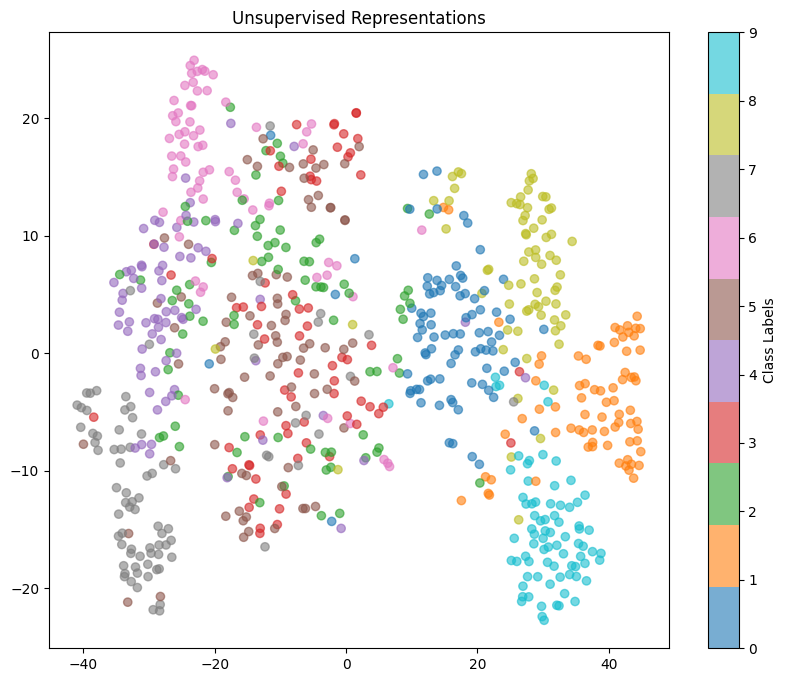

In [ ]:
features, labels_list = [], []

for i, (x, y) in enumerate(train_loader_clean):
    if i > 5: break
    x = x.to(device)
    with torch.no_grad():
        h = simclr_model.encoder.backbone(x)
        h = h.view(h.size(0), -1)
    features.append(h.cpu().numpy())
    labels_list.append(y.numpy())

features = np.concatenate(features)
labels_list = np.concatenate(labels_list)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_list, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Class Labels")
plt.title("Unsupervised Representations")
plt.show()

Unsupervised vs Supervised

Severity 1 | Unsupervised: 47.0% | Supervised: 44.8%
Severity 2 | Unsupervised: 43.2% | Supervised: 36.7%
Severity 3 | Unsupervised: 27.0% | Supervised: 30.3%
Severity 4 | Unsupervised: 21.3% | Supervised: 24.2%
Severity 5 | Unsupervised: 17.4% | Supervised: 23.2%


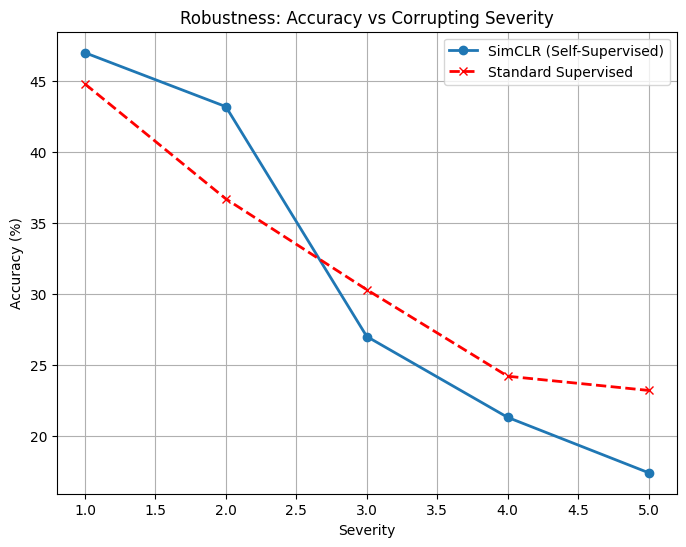

In [ ]:
severities = [1, 2, 3, 4, 5]
simclr_accs = []
supervised_accs = []

for s in severities:
    sim_correct, sup_correct = 0, 0
    total = 0

    for i in range(1000):
        img, label = test_set[i]
        img_np = np.array(img)

        corrupted_img = corrupt(img_np, severity=s, corruption_name='pixelate')

        t_img = clean_transform(corrupted_img).unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        with torch.no_grad():
            sim_out = simclr_model(t_img)
            _, sim_pred = torch.max(sim_out, 1)
            sim_correct += (sim_pred == label).item()

            sup_out = supervised_model(t_img)
            _, sup_pred = torch.max(sup_out, 1)
            sup_correct += (sup_pred == label).item()

        total += 1

    sim_acc = 100 * sim_correct / total
    sup_acc = 100 * sup_correct / total
    simclr_accs.append(sim_acc)
    supervised_accs.append(sup_acc)
    print(f"Severity {s} | Unsupervised: {sim_acc:.1f}% | Supervised: {sup_acc:.1f}%")

plt.figure(figsize=(8, 6))
plt.plot(severities, simclr_accs, marker='o', linewidth=2, label='SimCLR (Self-Supervised)')
plt.plot(severities, supervised_accs, marker='x', linewidth=2, linestyle='--', color='red', label='Standard Supervised')
plt.title("Robustness: Accuracy vs Corrupting Severity")
plt.xlabel("Severity")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

Try uploading yourself

Upload image


Saving Mahindra-XUV300-Exterior-147500.avif to Mahindra-XUV300-Exterior-147500 (1).avif


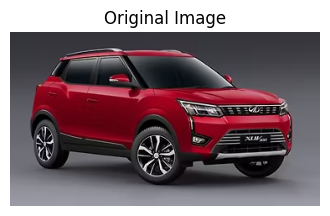

CLEAN RESULTS:
   Unsupervised Results:      car (100.0%)
   Supervised Results:  car (100.0%)


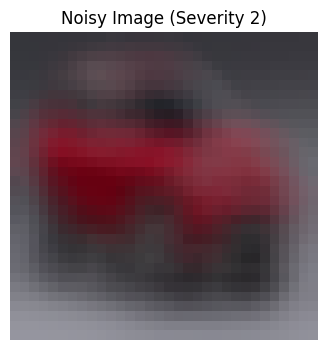

NOISY RESULTS:
   Unsupervised Results:      car (92.2%)
   Supervised Results:  cat (99.9%)


In [ ]:
from google.colab import files
from PIL import Image

classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("Upload image")
uploaded = files.upload()

inference_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

def get_prediction(model, tensor):
    model.eval()
    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, dim=1)
        conf, pred = torch.max(probs, 1)
        return classes[pred.item()], conf.item() * 100

for filename in uploaded.keys():
    original_img = Image.open(filename).convert('RGB')

    clean_tensor = inference_transform(original_img).unsqueeze(0).to(device)

    sim_pred, sim_conf = get_prediction(simclr_model, clean_tensor)
    sup_pred, sup_conf = get_prediction(supervised_model, clean_tensor)

    plt.figure(figsize=(4,4))
    plt.imshow(original_img)
    plt.axis('off')
    plt.title("Original Image")
    plt.show()

    print(f"CLEAN RESULTS:")
    print(f"   Unsupervised Results:      {sim_pred} ({sim_conf:.1f}%)")
    print(f"   Supervised Results:  {sup_pred} ({sup_conf:.1f}%)")

    img_np = np.array(original_img.resize((32, 32)))
    noisy_np = corrupt(img_np, severity=1, corruption_name='defocus_blur')
    noisy_img = Image.fromarray(noisy_np)

    noisy_tensor = inference_transform(noisy_img).unsqueeze(0).to(device)

    sim_noisy_pred, sim_noisy_conf = get_prediction(simclr_model, noisy_tensor)
    sup_noisy_pred, sup_noisy_conf = get_prediction(supervised_model, noisy_tensor)

    plt.figure(figsize=(4,4))
    plt.imshow(noisy_np)
    plt.axis('off')
    plt.title("Noisy Image (Severity 2)")
    plt.show()

    print(f"NOISY RESULTS:")
    print(f"   Unsupervised Results:      {sim_noisy_pred} ({sim_noisy_conf:.1f}%)")
    print(f"   Supervised Results:  {sup_noisy_pred} ({sup_noisy_conf:.1f}%)")